In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [42]:
macro = pd.read_csv("/kaggle/input/boost-data/macroeconomics.csv", index_col=0)
alex = pd.read_csv("/kaggle/input/boost-data/price_per_meter_2017_2024_v2.csv", index_col=0)
alex = pd.merge(macro, alex, on="Date", how="left")

In [43]:
alex = alex.drop(["Alexandria's Real Estate Ownership (GDP) (Thousands EGP)"], axis=1)

alex['Year'] = alex['Date'].str[:4]  
alex['Quarter'] = alex['Date'].str[5:].astype(int)

alex = alex.drop_duplicates(subset=["Date"]).reset_index(drop=True)

# drop 2024Q4 column
alex = alex[:-1]

og_columns = list(alex.columns)

# **Lags Selection Using Lasso**

In [44]:
# lags["Aqarmap Index_lag_1"]

In [45]:
lags = {}
for col in alex.columns:
    if col in ["Date", "Price Per Meter", "Year", "Quarter"]:
        continue

    for i in range(1,21):
        lag = col + "_lag_" + str(i)
        lags[lag] = alex[col].shift(i)
        
lags_df = pd.concat(lags, axis=1)

In [46]:
X = lags_df
X.fillna(0, inplace=True)
y = alex['Price Per Meter']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)

lasso = LassoCV(cv=tscv)
lasso.fit(X_scaled, y)

coef = pd.Series(lasso.coef_, index=X.columns)
selected_lags = coef[coef != 0].index.tolist()

print("Selected lags by LASSO:")
print(selected_lags)

Selected lags by LASSO:
['Aqarmap Index_lag_1', 'Aqarmap Index_lag_3', 'Aqarmap Index_lag_6', 'Aqarmap Index_lag_7', 'Aqarmap Index_lag_8', 'Aqarmap Index_lag_11', 'Aqarmap Index_lag_12', 'Aqarmap Index_lag_14', 'Aqarmap Index_lag_15', 'Aqarmap Index_lag_17', 'Aqarmap Index_lag_20', 'Inflation Rate_lag_2', 'Inflation Rate_lag_3', 'Inflation Rate_lag_4', 'Inflation Rate_lag_5', 'Inflation Rate_lag_6', 'Inflation Rate_lag_7', 'Inflation Rate_lag_8', 'Inflation Rate_lag_9', 'Inflation Rate_lag_10', 'Inflation Rate_lag_11', 'Inflation Rate_lag_13', 'Inflation Rate_lag_14', 'Inflation Rate_lag_15', 'Inflation Rate_lag_16', 'Inflation Rate_lag_17', 'Inflation Rate_lag_19', 'Inflation Rate_lag_20', 'Domestic Liquidity_lag_1', 'Domestic Liquidity_lag_3', 'Domestic Liquidity_lag_5', 'Domestic Liquidity_lag_8', 'Domestic Liquidity_lag_12', 'Money Supply_lag_3', 'Money Supply_lag_5', 'Money Supply_lag_7', "Egypt's Real Estate Activities (GDP) (Millions EGP)_lag_4", "Egypt's Real Estate Activities

In [47]:
lags_df = lags_df.drop(columns=[col for col in lags_df.columns if col not in selected_lags], axis=1)

In [48]:
alex = pd.concat([alex, lags_df], axis=1)

In [49]:
alex.set_index("Date", inplace=True)

In [50]:
ppm = alex["Price Per Meter"]

In [51]:
alex["Price Per Meter"] = alex["Price Per Meter"] - alex["Price Per Meter"].shift(1)

In [52]:
alex = alex.dropna(subset=['Price Per Meter'])

# **Model Preprocessing**

In [53]:
X = alex.drop(["Price Per Meter"], axis=1)
y = alex["Price Per Meter"]

pca = PCA(n_components=8)
X.fillna(0, inplace=True)
X_pca = pca.fit_transform(X.drop(["Year", "Quarter"], axis=1))

df_pca = pd.DataFrame(X_pca, columns=[f'pca_{i+1}' for i in range(X_pca.shape[1])])
X = pd.concat([alex[['Year', 'Quarter']].reset_index(drop=True), df_pca], axis=1)

X.replace(0, np.nan, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

X_train["Quarter"] = X_train["Quarter"].astype(int)
X_test["Quarter"] = X_test["Quarter"].astype(int)
X_test["Year"] = X_test["Year"].astype(int)
X_train["Year"] = X_train["Year"].astype(int)

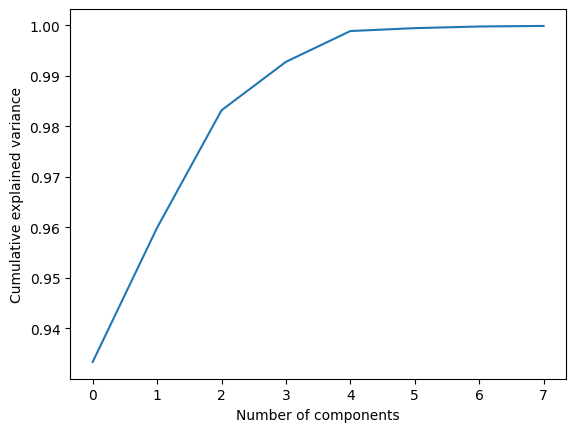

In [54]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [55]:
x_scaler = MinMaxScaler()

X_train = pd.DataFrame(x_scaler.fit_transform(X_train), 
                     columns=X_train.columns, 
                     index=X_train.index)

X_test = pd.DataFrame(x_scaler.fit_transform(X_test), 
                     columns=X_test.columns, 
                     index=X_test.index)

# X_train = x_scaler.fit_transform(X_train)

# X_test = x_scaler.fit_transform(X_test)

y_scaler = MinMaxScaler()

y_test = y_scaler.fit_transform(y_test)

y_train = y_scaler.fit_transform(y_train)

# **Model Training**

In [56]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=7,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.21963	validation_1-rmse:0.34132
[100]	validation_0-rmse:0.10967	validation_1-rmse:0.25334
[200]	validation_0-rmse:0.06133	validation_1-rmse:0.21326
[300]	validation_0-rmse:0.03604	validation_1-rmse:0.19704
[400]	validation_0-rmse:0.02156	validation_1-rmse:0.19093
[500]	validation_0-rmse:0.01297	validation_1-rmse:0.18855
[600]	validation_0-rmse:0.00783	validation_1-rmse:0.18766
[700]	validation_0-rmse:0.00474	validation_1-rmse:0.18736
[800]	validation_0-rmse:0.00289	validation_1-rmse:0.18724
[900]	validation_0-rmse:0.00179	validation_1-rmse:0.18719
[999]	validation_0-rmse:0.00117	validation_1-rmse:0.18718


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

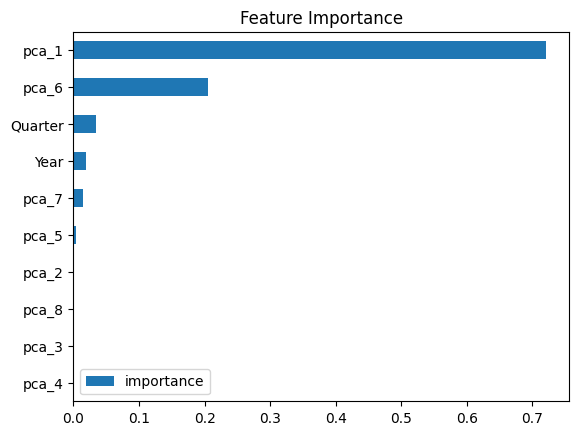

In [57]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

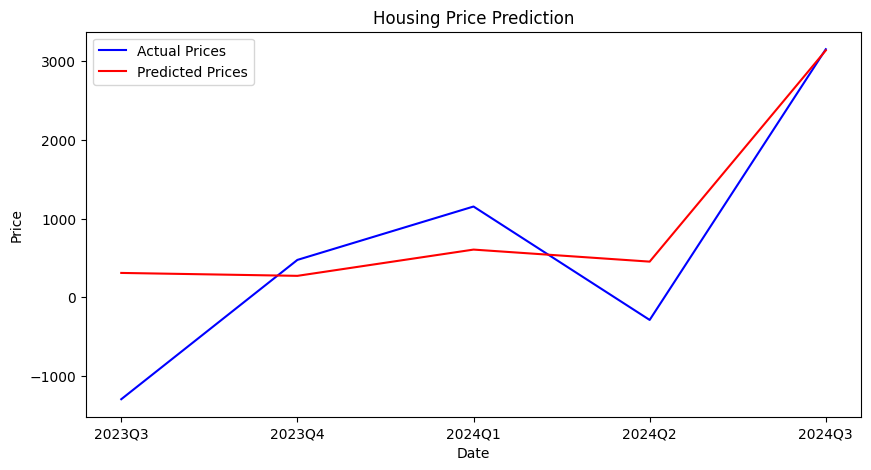

In [58]:
pred = reg.predict(X_test)
pred = y_scaler.inverse_transform([pred])
pred = pred.reshape(pred.shape[1], 1)
y_test = y_scaler.inverse_transform(y_test)

plt.figure(figsize=(10,5))
plt.plot(alex.index[-len(y_test):], y_test, label="Actual Prices", color='blue')
plt.plot(alex.index[-len(pred):], pred, label="Predicted Prices", color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title("Housing Price Prediction")
plt.show()

In [59]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 832.50
MAE: 622.08
R² Score: 0.6908


# **Forecasting**

In [60]:
macro_test = pd.read_csv("/kaggle/input/macro-2025-2028/macro_pred_2025_2028.csv", index_col=0)

In [61]:
macro_test.index.name = "Date"

In [62]:
macro_test = macro_test.rename(columns={"Real Estate Activitie":"Egypt's Real Estate Activities (GDP) (Millions EGP)",
                          "Points":"Aqarmap Index"})

In [63]:
macro_test_lags = {}
for col in macro_test.columns:
    for i in range(1,21):
        lag = col + "_lag_" + str(i)
        macro_test_lags[lag] = macro_test[col].shift(i)
        
macro_test_lags_df = pd.concat(macro_test_lags, axis=1)

In [64]:
macro_test = pd.concat([macro_test, macro_test_lags_df], axis=1)
macro_test = macro_test.drop(columns=[col for col in macro_test.columns if col not in alex.columns], axis=1)

In [65]:
macro_test['Year'] = macro_test.index.str[:4].astype(int)
macro_test['Quarter'] = macro_test.index.str[5:].astype(int)

In [66]:
macro_test.fillna(0, inplace=True)
macro_test_pca = pca.fit_transform(macro_test.drop(["Year", "Quarter"], axis=1))

df_pca = pd.DataFrame(macro_test_pca, columns=[f'pca_{i+1}' for i in range(macro_test_pca.shape[1])])
macro_test_pca = pd.concat([macro_test[['Year', 'Quarter']].reset_index(drop=True), df_pca], axis=1)

macro_test_pca.replace(0, np.nan, inplace=True)

In [67]:
macro_test_pca = pd.DataFrame(x_scaler.fit_transform(macro_test_pca), 
                     columns=macro_test_pca.columns, 
                     index=macro_test_pca.index)

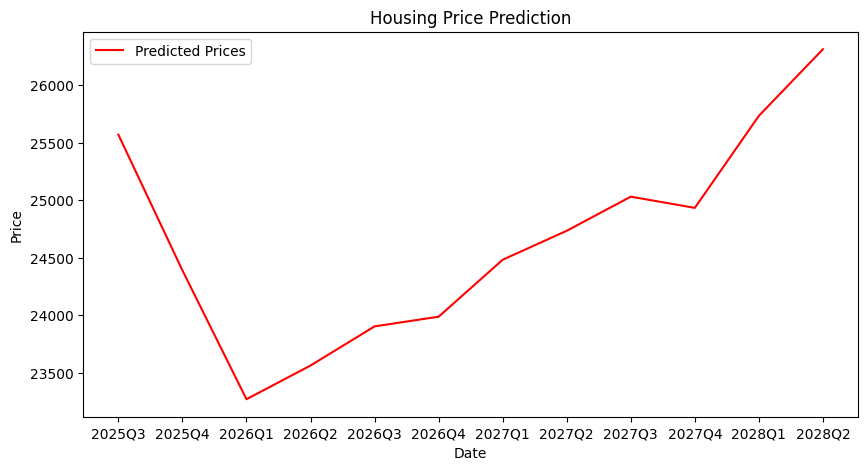

In [68]:
forecast = reg.predict(macro_test_pca)
forecast = y_scaler.inverse_transform([forecast])
forecast = forecast.reshape(forecast.shape[1], 1)
forecast = ppm.iloc[-1] + np.cumsum(forecast)

plt.figure(figsize=(10,5))
plt.plot(macro_test.index[-len(forecast):], forecast, label="Predicted Prices", color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title("Housing Price Prediction")
plt.show()

In [77]:
dates = list(macro_test.index[-len(forecast):])
forecast = list(forecast)
for i in range(len(forecast)):
    print(dates[i] + " => " + str(round(forecast[i], 2)) + " L.E.")

2025Q3 => 25568.61 L.E.
2025Q4 => 24388.43 L.E.
2026Q1 => 23268.37 L.E.
2026Q2 => 23561.37 L.E.
2026Q3 => 23901.84 L.E.
2026Q4 => 23985.8 L.E.
2027Q1 => 24481.05 L.E.
2027Q2 => 24733.04 L.E.
2027Q3 => 25029.72 L.E.
2027Q4 => 24932.14 L.E.
2028Q1 => 25732.46 L.E.
2028Q2 => 26311.68 L.E.
